# German Credit Dataset

## Import Libraries

In [213]:
import numpy as np
import pandas as pd
import re
#for EDA
from ydata_profiling import ProfileReport

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#for preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder

#for model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as nb
from sklearn.linear_model import LogisticRegression as lr
from sklearn.tree import DecisionTreeClassifier as dt 
from sklearn.svm import SVC as vc
from sklearn.ensemble import RandomForestClassifier as rcl
import sklearn.metrics as sm

## Loading the Dataset

### Importing data

In [214]:
German_data = pd.read_csv('data/german.data')
German_data.head()

,A11 6 A34 A43 1169 A65 A75 4 A93 A101 4 A121 67 A143 A152 2 A173 1 A192 A201 1
0,A12 48 A32 A43 5951 A61 A73 2 A92 A101 2 A121 ...
1,A14 12 A34 A46 2096 A61 A74 2 A93 A101 3 A121 ...
2,A11 42 A32 A42 7882 A61 A74 2 A93 A103 4 A122 ...
3,A11 24 A33 A40 4870 A61 A73 3 A93 A101 4 A124 ...
4,A14 36 A32 A46 9055 A65 A73 2 A93 A101 4 A124 ...


As we can see, the data currently has no column name and all values are status codes. We need to restructure the dataset by adding column headers and replace status codes with descriptive labes for more effective analysis and reporting.

In [215]:
col_names = ["checking-account","duration","credit-history",\
         "purpose","credit-amount","savings-account","employment-since",\
         "installment-rate","personal-status-and-sex",\
         "other-debtors","residence-since","property","age",\
        "other-installment","housing","existing-credits",\
        "job","number-of-people-provide-maintenance-for","telephone","foreign-worker","risk"]
checking_account={'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
savings_account={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
employment_since={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
other_debtors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
other_installment={'A143':"none", 'A142':"store", 'A141':"bank"}
housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
telephone={'A192':"yes", 'A191':"none"}
foreign_worker={'A201':"yes", 'A202':"no"}
risk={1:"Good Risk", 2:"Bad Risk"}


In [216]:
German_data = pd.read_csv('data/german.data', names=col_names, sep=" ")
German_data['checking-account'] = German_data['checking-account'].map(checking_account)
German_data['credit-history'] = German_data['credit-history'].map(credit_history)
German_data['purpose'] = German_data['purpose'].map(purpose)
German_data['savings-account'] = German_data['savings-account'].map(savings_account)
German_data['employment-since'] = German_data['employment-since'].map(employment_since)
German_data['personal-status-and-sex'] = German_data['personal-status-and-sex'].map(personal_status_and_sex)
German_data['other-debtors'] = German_data['other-debtors'].map(other_debtors)
German_data['property'] = German_data['property'].map(property)
German_data['other-installment'] = German_data['other-installment'].map(other_installment)
German_data['housing'] = German_data['housing'].map(housing)
German_data['job'] = German_data['job'].map(job)
German_data['telephone'] = German_data['telephone'].map(telephone)
German_data['foreign-worker'] = German_data['foreign-worker'].map(foreign_worker)
German_data['risk'] = German_data['risk'].map(risk)
German_data.head()

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,personal-status-and-sex,other-debtors,...,property,age,other-installment,housing,existing-credits,job,number-of-people-provide-maintenance-for,telephone,foreign-worker,risk
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,male:single,none,...,real estate,67,none,own,2,skilled employee / official,1,yes,yes,Good Risk
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,female:divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad Risk
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,2,male:single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good Risk
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,male:single,guarantor,...,savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good Risk
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,male:single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad Risk


In [217]:
German_data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit-amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment-rate,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence-since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing-credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
number-of-people-provide-maintenance-for,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [218]:
German_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   checking-account                          1000 non-null   object
 1   duration                                  1000 non-null   int64 
 2   credit-history                            1000 non-null   object
 3   purpose                                   1000 non-null   object
 4   credit-amount                             1000 non-null   int64 
 5   savings-account                           1000 non-null   object
 6   employment-since                          1000 non-null   object
 7   installment-rate                          1000 non-null   int64 
 8   personal-status-and-sex                   1000 non-null   object
 9   other-debtors                             1000 non-null   object
 10  residence-since                           1000 no

It seems like this datasat does not have any missing values.

## Data Exploration and Visualization

In [219]:
profile = ProfileReport(German_data, title = "Pandas Profiling Report for German Credit dataset")
profile.to_file(output_file="German_Credit_profiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [220]:
profile

### Categorical Column Analysis

#### Other-debtors

According to the above profile, it is clear that 'Other-debtors' is a biased data as most of the people are not debtors. 

### Numerical Column Analysis

#### Credit-amount

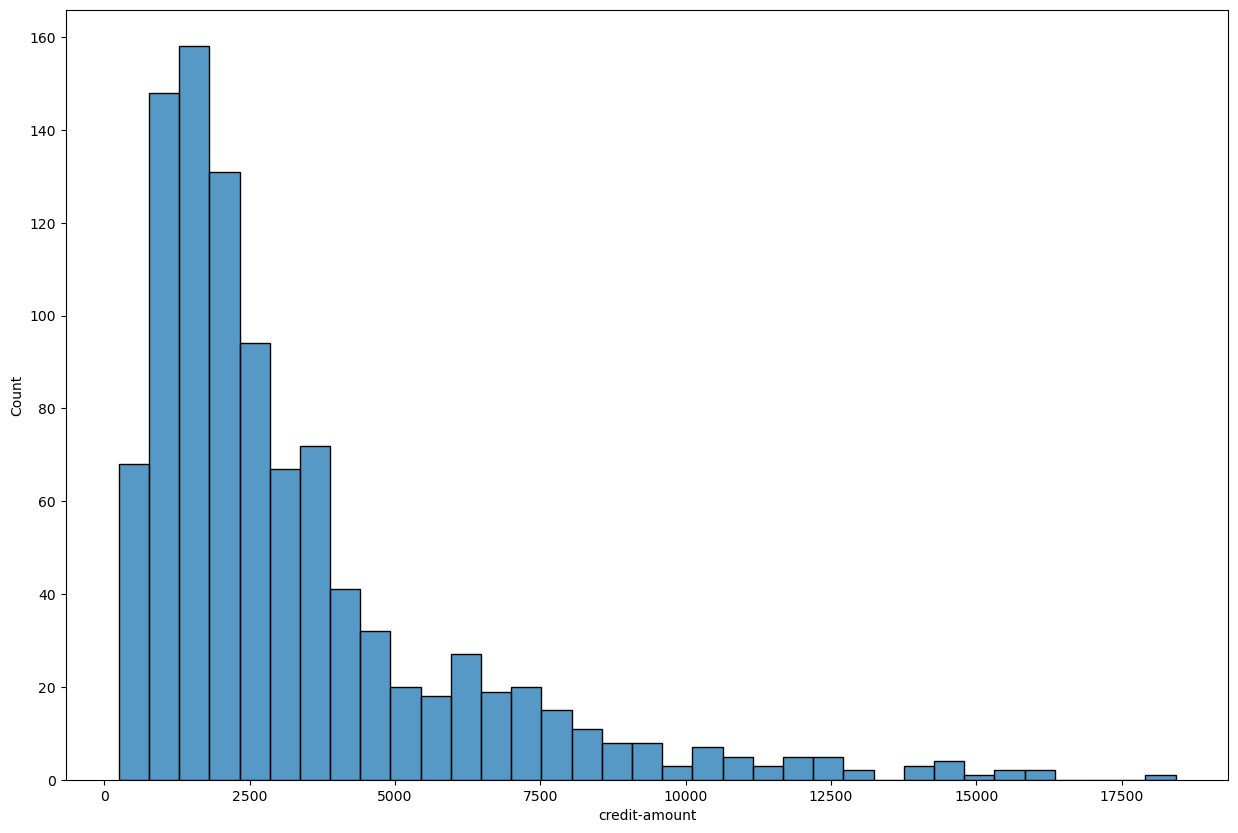

In [221]:
plt.figure(figsize=(15,10))
sns.histplot(x=German_data['credit-amount'])
plt.show()

It is clear that the 'credit-amount' following the Gaussian distribution. 

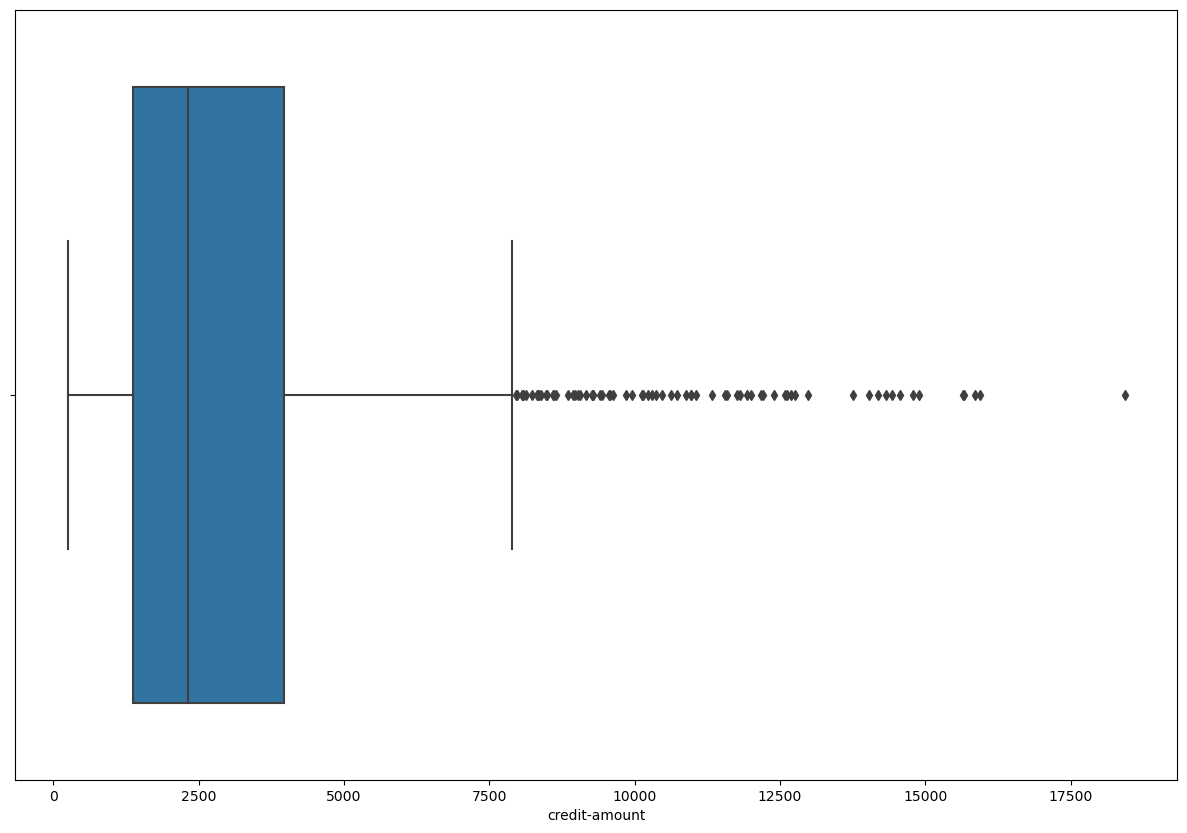

In [222]:
plt.figure(figsize=(15,10))
sns.boxplot(x=German_data['credit-amount'])
plt.show()

However, this column is facing with the problem that there are many outliers from 8000 to over 17500. So, instead of using standard scaling, we should use log transformation to deal with those outliers. Morever, we can try with some outliers treatment like IQR.

#### Age

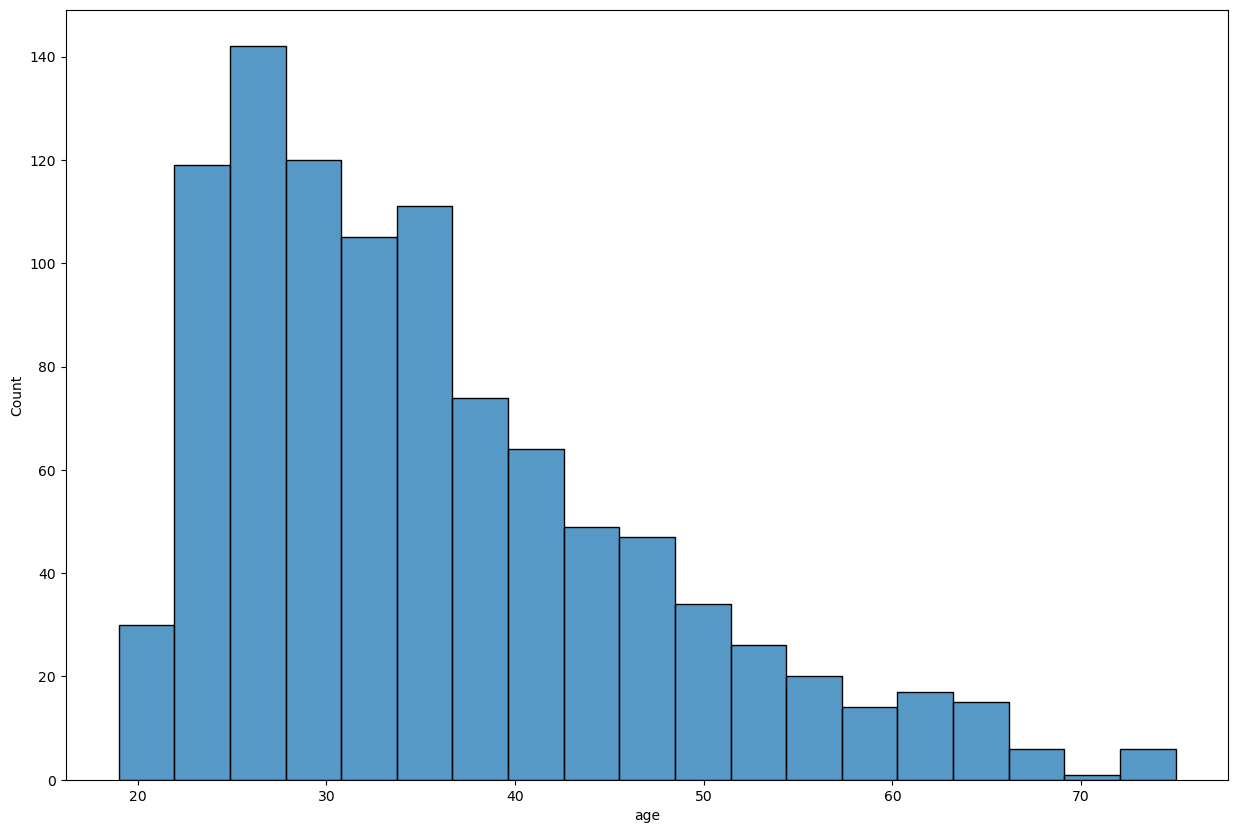

In [223]:
plt.figure(figsize=(15,10))
sns.histplot(x=German_data['age'])
plt.show()

'Age' column seems to have same pattern with the 'Credit-amount' column. Now we will check whether it includes many outliers or not.

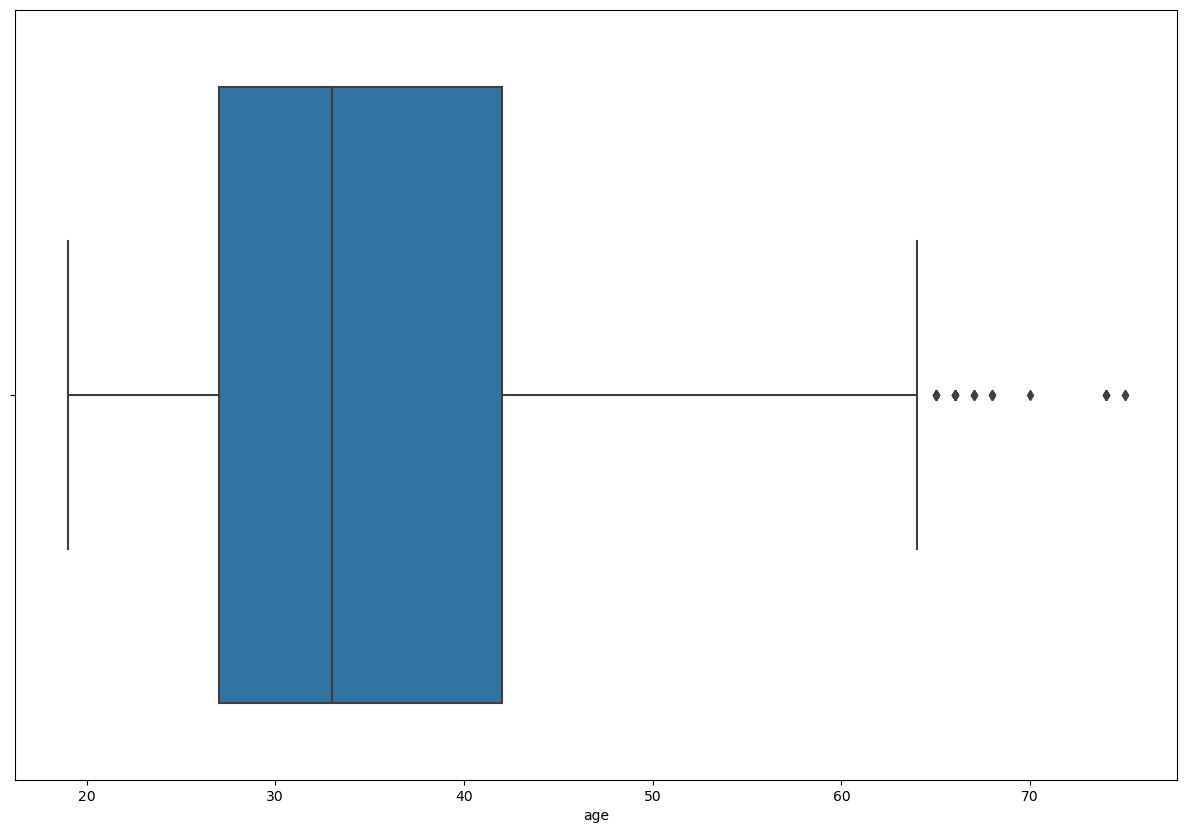

In [224]:
plt.figure(figsize=(15,10))
sns.boxplot(x=German_data['age'])
plt.show()

Based on the chart, the majority of participants'ages in the survey fall within the range of 27 to 42, with relatively few outliers. Therefore, we can use standard scaling.

#### duration

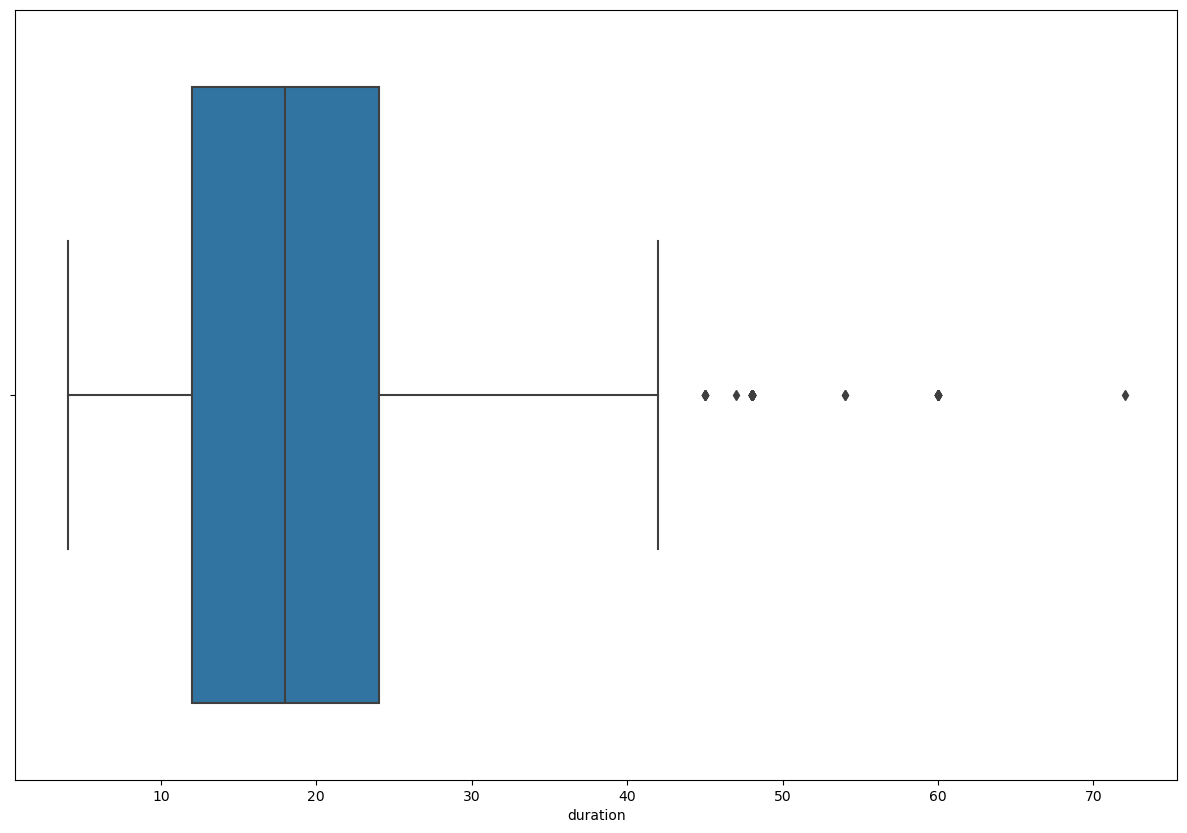

In [225]:
plt.figure(figsize=(15,10))
sns.boxplot(x=German_data['duration'])
plt.show()

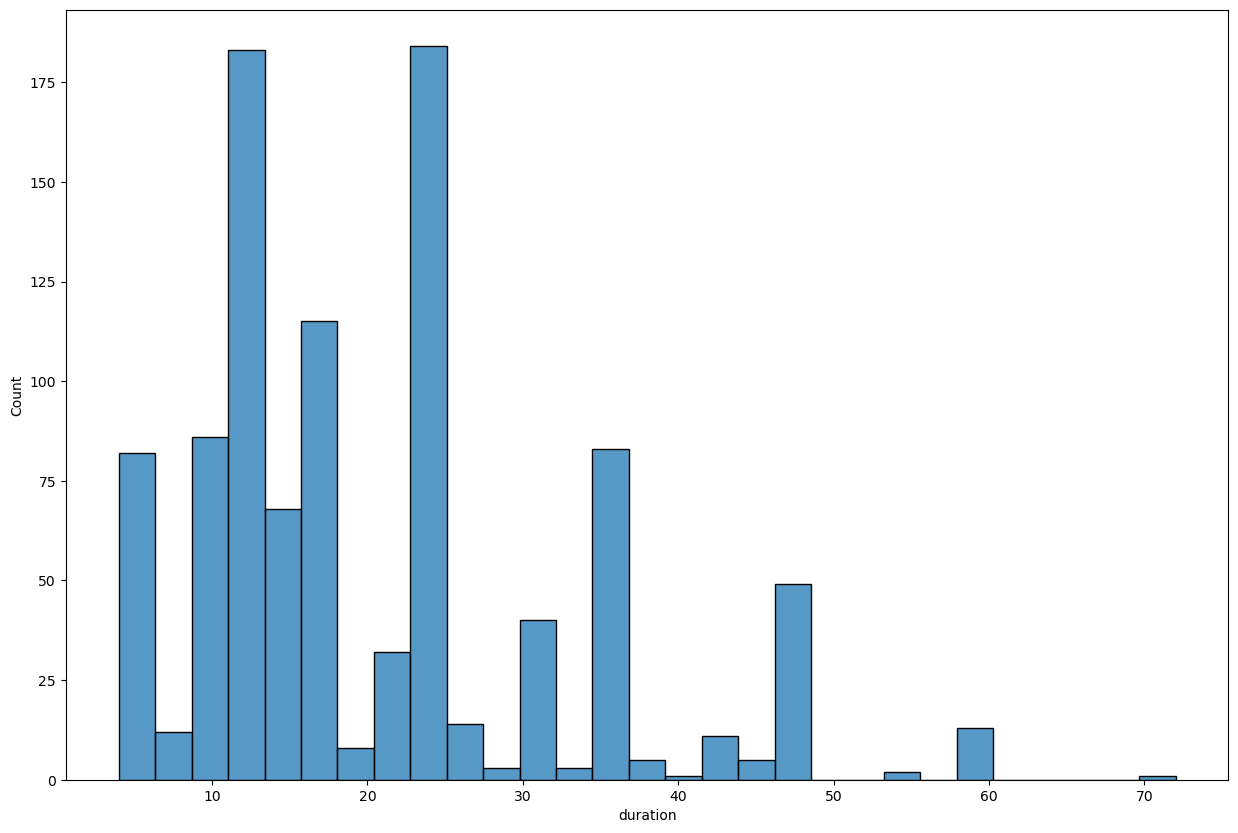

In [226]:
plt.figure(figsize=(15,10))
sns.histplot(x=German_data['duration'])
plt.show()

The distribution of 'duration' column is uncertain, with data concentrated between 12 and 24. Therefore, we can use standard scaling.

## Data Preprocessing

In [227]:
categorical_columns = list(German_data.select_dtypes(include=['object']).columns)
print(categorical_columns)
numerical_columns = list(German_data.select_dtypes(include=['int64', 'float64']).columns)
print(numerical_columns)

['checking-account', 'credit-history', 'purpose', 'savings-account', 'employment-since', 'personal-status-and-sex', 'other-debtors', 'property', 'other-installment', 'housing', 'job', 'telephone', 'foreign-worker', 'risk']
['duration', 'credit-amount', 'installment-rate', 'residence-since', 'age', 'existing-credits', 'number-of-people-provide-maintenance-for']


### Outliers Treatment

In [228]:
def outlier_thresholds(column):
    sorted(column)
    Q1 = np.quantile(column, 0.25)
    Q3 = np.quantile(column, 0.75)
    IQR = Q3-Q1
    lower_bound = Q1-(1.5*IQR)
    upper_bound = Q3+(1.5*IQR)
    return lower_bound, upper_bound


In [229]:
outliers_column = ['age', 'credit-amount', 'duration']
for i in outliers_column:
    lowerbound, upperbound = outlier_thresholds(German_data[i])
    German_data[i].loc[(German_data[i] < lowerbound)] = lowerbound
    German_data[i].loc[(German_data[i] > upperbound)] = upperbound

C:\Users\Storm\AppData\Local\Temp\ipykernel_624\3640519208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  German_data[i].loc[(German_data[i] < lowerbound)] = lowerbound
C:\Users\Storm\AppData\Local\Temp\ipykernel_624\3640519208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  German_data[i].loc[(German_data[i] < lowerbound)] = lowerbound
C:\Users\Storm\AppData\Local\Temp\ipykernel_624\3640519208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

### Label Encoding

In [230]:
label_encoder = LabelEncoder()
for i in categorical_columns:
    German_data[i] = label_encoder.fit_transform(German_data[i])
German_data

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,personal-status-and-sex,other-debtors,...,property,age,other-installment,housing,existing-credits,job,number-of-people-provide-maintenance-for,telephone,foreign-worker,risk
0,1,6,1,7,1169.0,4,3,4,3,2,...,1,64.5,1,1,2,1,1,1,1,1
1,0,42,3,7,5951.0,2,0,2,0,2,...,1,22.0,1,1,1,1,1,0,1,0
2,3,12,1,4,2096.0,2,1,2,3,2,...,1,49.0,1,1,1,3,2,0,1,1
3,1,42,3,5,7882.0,2,1,2,3,1,...,2,45.0,1,0,1,1,2,0,1,1
4,1,24,2,1,4870.0,2,0,3,3,2,...,3,53.0,1,0,2,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,12,3,5,1736.0,2,1,3,0,2,...,1,31.0,1,1,1,3,1,0,1,1
996,1,30,3,2,3857.0,2,0,4,1,2,...,2,40.0,1,1,1,0,1,1,1,1
997,3,12,3,7,804.0,2,3,4,3,2,...,0,38.0,1,1,1,1,1,0,1,1
998,1,42,3,7,1845.0,2,0,4,3,2,...,3,23.0,1,0,1,1,1,1,1,0


In [231]:
German_data.describe().T

,count,mean,std,min,25%,50%,75%,max
checking-account,1000.0,1.5820,1.253334,0.0,0.0,1.0,3.00,3.000
duration,1000.0,20.3070,10.615151,4.0,12.0,18.0,24.00,42.000
credit-history,1000.0,2.2190,1.064035,0.0,1.0,3.0,3.00,4.000
purpose,1000.0,3.8700,2.720018,0.0,1.0,5.0,7.00,9.000
credit-amount,1000.0,3051.1010,2187.140403,250.0,1365.5,2319.5,3972.25,7882.375
savings-account,1000.0,2.1450,1.111400,0.0,2.0,2.0,2.00,4.000
employment-since,1000.0,1.5250,1.344315,0.0,0.0,1.0,3.00,4.000
installment-rate,1000.0,2.9730,1.118715,1.0,2.0,3.0,4.00,4.000
personal-status-and-sex,1000.0,1.8780,1.350904,0.0,0.0,3.0,3.00,3.000
other-debtors,1000.0,1.8660,0.445244,0.0,2.0,2.0,2.00,2.000


### Scaling The Data

#### Log Transformation

In [232]:
German_data['credit-amount'] = np.log(German_data['credit-amount'])

#### Standard Scaling

In [233]:
standard_scaler = StandardScaler()
German_data['age'] = standard_scaler.fit_transform(German_data['age'].values.reshape(-1, 1))
German_data['duration'] = standard_scaler.fit_transform(German_data['duration'].values.reshape(-1, 1))

#### Min-Max Scaling

In [234]:
col_names = German_data.columns
min_max_scaler = MinMaxScaler()
German_data[German_data.columns.difference(['credit-amount', 'age', 'duration'])] = min_max_scaler.fit_transform(German_data[German_data.columns.difference(['credit-amount', 'age', 'duration'])])
German_data = pd.DataFrame(German_data, columns= col_names)
German_data

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,personal-status-and-sex,other-debtors,...,property,age,other-installment,housing,existing-credits,job,number-of-people-provide-maintenance-for,telephone,foreign-worker,risk
0,0.333333,0.052632,0.25,0.777778,0.120408,1.0,0.75,1.000000,1.000000,1.0,...,0.333333,1.000000,0.5,0.5,0.333333,0.333333,0.0,1.0,1.0,1.0
1,0.000000,1.000000,0.75,0.777778,0.746950,0.5,0.00,0.333333,0.000000,1.0,...,0.333333,0.065934,0.5,0.5,0.000000,0.333333,0.0,0.0,1.0,0.0
2,1.000000,0.210526,0.25,0.444444,0.241864,0.5,0.25,0.333333,1.000000,1.0,...,0.333333,0.659341,0.5,0.5,0.000000,1.000000,1.0,0.0,1.0,1.0
3,0.333333,1.000000,0.75,0.555556,0.999951,0.5,0.25,0.333333,1.000000,0.5,...,0.666667,0.571429,0.5,0.0,0.000000,0.333333,1.0,0.0,1.0,1.0
4,0.333333,0.526316,0.50,0.111111,0.605316,0.5,0.00,0.666667,1.000000,1.0,...,1.000000,0.747253,0.5,0.0,0.333333,0.333333,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.000000,0.210526,0.75,0.555556,0.194697,0.5,0.25,0.666667,0.000000,1.0,...,0.333333,0.263736,0.5,0.5,0.000000,1.000000,0.0,0.0,1.0,1.0
996,0.333333,0.684211,0.75,0.222222,0.472592,0.5,0.00,1.000000,0.333333,1.0,...,0.666667,0.461538,0.5,0.5,0.000000,0.000000,0.0,1.0,1.0,1.0
997,1.000000,0.210526,0.75,0.777778,0.072586,0.5,0.75,1.000000,1.000000,1.0,...,0.000000,0.417582,0.5,0.5,0.000000,0.333333,0.0,0.0,1.0,1.0
998,0.333333,1.000000,0.75,0.777778,0.208978,0.5,0.00,1.000000,1.000000,1.0,...,1.000000,0.087912,0.5,0.0,0.000000,0.333333,0.0,1.0,1.0,0.0


## Model Building

In [235]:
German_data

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,personal-status-and-sex,other-debtors,...,property,age,other-installment,housing,existing-credits,job,number-of-people-provide-maintenance-for,telephone,foreign-worker,risk
0,0.333333,0.052632,0.25,0.777778,0.120408,1.0,0.75,1.000000,1.000000,1.0,...,0.333333,1.000000,0.5,0.5,0.333333,0.333333,0.0,1.0,1.0,1.0
1,0.000000,1.000000,0.75,0.777778,0.746950,0.5,0.00,0.333333,0.000000,1.0,...,0.333333,0.065934,0.5,0.5,0.000000,0.333333,0.0,0.0,1.0,0.0
2,1.000000,0.210526,0.25,0.444444,0.241864,0.5,0.25,0.333333,1.000000,1.0,...,0.333333,0.659341,0.5,0.5,0.000000,1.000000,1.0,0.0,1.0,1.0
3,0.333333,1.000000,0.75,0.555556,0.999951,0.5,0.25,0.333333,1.000000,0.5,...,0.666667,0.571429,0.5,0.0,0.000000,0.333333,1.0,0.0,1.0,1.0
4,0.333333,0.526316,0.50,0.111111,0.605316,0.5,0.00,0.666667,1.000000,1.0,...,1.000000,0.747253,0.5,0.0,0.333333,0.333333,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.000000,0.210526,0.75,0.555556,0.194697,0.5,0.25,0.666667,0.000000,1.0,...,0.333333,0.263736,0.5,0.5,0.000000,1.000000,0.0,0.0,1.0,1.0
996,0.333333,0.684211,0.75,0.222222,0.472592,0.5,0.00,1.000000,0.333333,1.0,...,0.666667,0.461538,0.5,0.5,0.000000,0.000000,0.0,1.0,1.0,1.0
997,1.000000,0.210526,0.75,0.777778,0.072586,0.5,0.75,1.000000,1.000000,1.0,...,0.000000,0.417582,0.5,0.5,0.000000,0.333333,0.0,0.0,1.0,1.0
998,0.333333,1.000000,0.75,0.777778,0.208978,0.5,0.00,1.000000,1.000000,1.0,...,1.000000,0.087912,0.5,0.0,0.000000,0.333333,0.0,1.0,1.0,0.0


In [236]:
features = German_data[German_data.columns.difference(['risk'])]
target = German_data['risk']
features

,age,checking-account,credit-amount,credit-history,duration,employment-since,existing-credits,foreign-worker,housing,installment-rate,job,number-of-people-provide-maintenance-for,other-debtors,other-installment,personal-status-and-sex,property,purpose,residence-since,savings-account,telephone
0,1.000000,0.333333,0.120408,0.25,0.052632,0.75,0.333333,1.0,0.5,1.000000,0.333333,0.0,1.0,0.5,1.000000,0.333333,0.777778,1.000000,1.0,1.0
1,0.065934,0.000000,0.746950,0.75,1.000000,0.00,0.000000,1.0,0.5,0.333333,0.333333,0.0,1.0,0.5,0.000000,0.333333,0.777778,0.333333,0.5,0.0
2,0.659341,1.000000,0.241864,0.25,0.210526,0.25,0.000000,1.0,0.5,0.333333,1.000000,1.0,1.0,0.5,1.000000,0.333333,0.444444,0.666667,0.5,0.0
3,0.571429,0.333333,0.999951,0.75,1.000000,0.25,0.000000,1.0,0.0,0.333333,0.333333,1.0,0.5,0.5,1.000000,0.666667,0.555556,1.000000,0.5,0.0
4,0.747253,0.333333,0.605316,0.50,0.526316,0.00,0.333333,1.0,0.0,0.666667,0.333333,1.0,1.0,0.5,1.000000,1.000000,0.111111,1.000000,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.263736,1.000000,0.194697,0.75,0.210526,0.25,0.000000,1.0,0.5,0.666667,1.000000,0.0,1.0,0.5,0.000000,0.333333,0.555556,1.000000,0.5,0.0
996,0.461538,0.333333,0.472592,0.75,0.684211,0.00,0.000000,1.0,0.5,1.000000,0.000000,0.0,1.0,0.5,0.333333,0.666667,0.222222,1.000000,0.5,1.0
997,0.417582,1.000000,0.072586,0.75,0.210526,0.75,0.000000,1.0,0.5,1.000000,0.333333,0.0,1.0,0.5,1.000000,0.000000,0.777778,1.000000,0.5,0.0
998,0.087912,0.333333,0.208978,0.75,1.000000,0.00,0.000000,1.0,0.0,1.000000,0.333333,0.0,1.0,0.5,1.000000,1.000000,0.777778,1.000000,0.5,1.0


### Train-test splitting

In [237]:
feature_train, feature_test, label_train, label_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Model

#### Accuracy calculating

In [238]:
def calc_accuracy(method, label_test, pred):
  print("accuracy score for ", method, sm.accuracy_score(label_test,pred))
  print("precision_score for ", method, sm.precision_score(label_test,pred,average='micro'))
  print("f1 score for ", method, sm.f1_score(label_test,pred,average='micro'))
  print("recall score for ", method, sm.recall_score(label_test,pred,average='micro'))
  accuracy = sm.accuracy_score(label_test,pred)
  return accuracy

#### Logistic Regression

In [239]:
clf = lr(max_iter=150)
clf.fit(feature_train, label_train)

LogisticRegression(max_iter=150)

In [240]:
pred = clf.predict(feature_test)
lr_accuracy = calc_accuracy("Logistic Regression", label_test, pred)

accuracy score for  Logistic Regression 0.72
precision_score for  Logistic Regression 0.72
f1 score for  Logistic Regression 0.72
recall score for  Logistic Regression 0.72


#### Gaussian Naive Bayes

In [241]:
clf = nb()
clf.fit(feature_train, label_train)

GaussianNB()

In [242]:
pred = clf.predict(feature_test)
nb_accuracy = calc_accuracy("Gaussian Naive Bayes", label_test, pred)

accuracy score for  Gaussian Naive Bayes 0.725
precision_score for  Gaussian Naive Bayes 0.725
f1 score for  Gaussian Naive Bayes 0.7250000000000001
recall score for  Gaussian Naive Bayes 0.725


#### Linear Support Vector Machine

In [243]:
clf = vc(C=10, gamma=0.1, kernel='rbf')
clf.fit(feature_train, label_train)

SVC(C=10, gamma=0.1)

In [244]:
pred = clf.predict(feature_test)
svc_accuracy = calc_accuracy("SVC", label_test, pred)

accuracy score for  SVC 0.75
precision_score for  SVC 0.75
f1 score for  SVC 0.75
recall score for  SVC 0.75


#### K-Nearest Neighbors

In [245]:
clf = knn(n_neighbors=25)
clf.fit(feature_train, label_train)

KNeighborsClassifier(n_neighbors=25)

In [246]:
pred = clf.predict(feature_test.values)
knn_accuracy = calc_accuracy("KNN", label_test, pred)

accuracy score for  KNN 0.74
precision_score for  KNN 0.74
f1 score for  KNN 0.74
recall score for  KNN 0.74


c:\Users\Storm\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


#### Decision Tree Classifier

In [247]:
clf = dt(min_impurity_decrease=0.05)
clf.fit(feature_train, label_train)

DecisionTreeClassifier(min_impurity_decrease=0.05)

In [248]:
pred = clf.predict(feature_test)
dt_accuracy = calc_accuracy("Decision Tree Classifer", label_test, pred)

accuracy score for  Decision Tree Classifer 0.705
precision_score for  Decision Tree Classifer 0.705
f1 score for  Decision Tree Classifer 0.705
recall score for  Decision Tree Classifer 0.705


## Evaluation

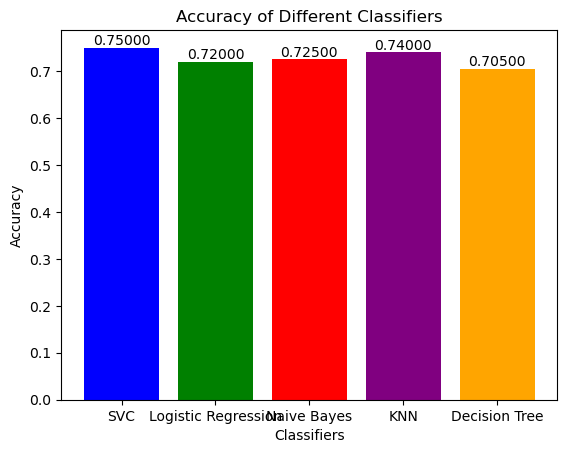

In [249]:
algorithms = ["SVC", "Logistic Regression", "Naive Bayes", "KNN", "Decision Tree"]
accuracy = [svc_accuracy, lr_accuracy, nb_accuracy, knn_accuracy, dt_accuracy]
colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.bar(algorithms, accuracy, color = colors)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Classifiers")
for i in range(len(algorithms)):
    plt.text(algorithms[i], accuracy[i], f'{accuracy[i]:.5f}', ha='center', va='bottom')
plt.show()